In [21]:
import warnings
import pandas as pd
import seaborn as sns

import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from plotnine import ggplot, geom_histogram, aes, theme_classic, labs, theme, scale_fill_manual, scale_y_continuous

from utils import add_normalized_colums

sns.set(rc={'text.usetex' : True}, font_scale=1, context='paper')
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# Plot an example breast cancer SD-SCM dataset from Llama-3-8b

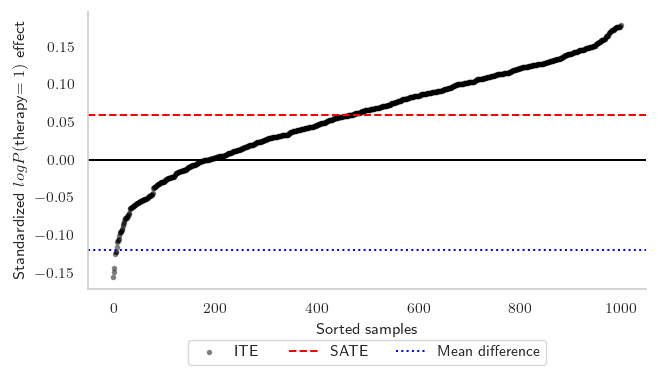

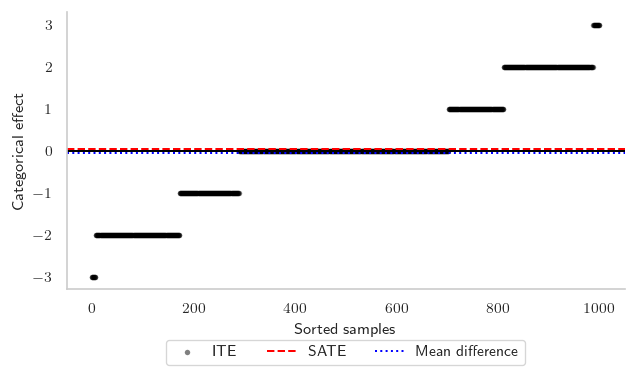

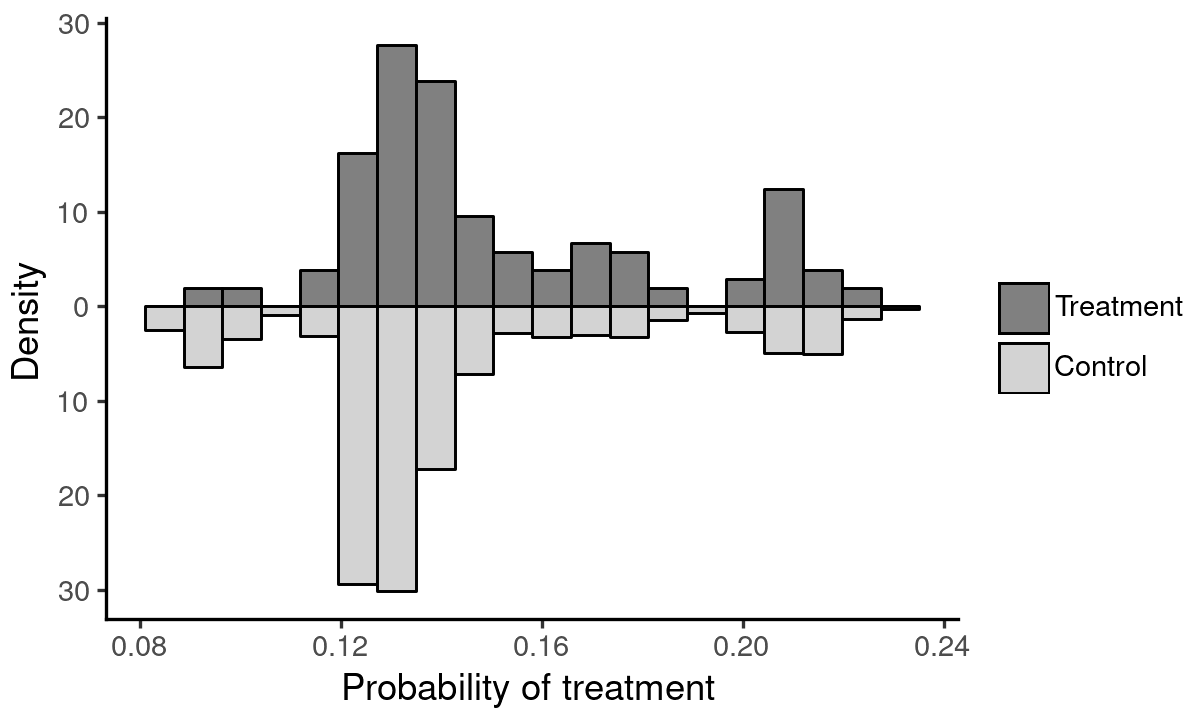

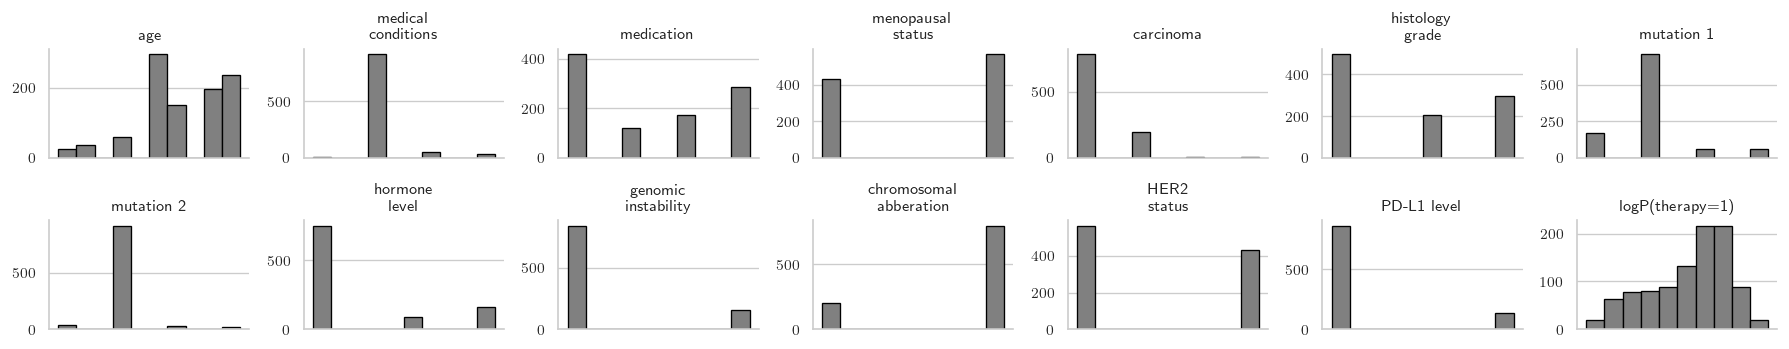

In [77]:
df_path = 'data/cancer_example/llama-3-8b/llama-3-8b_bcancer_131.csv'
outcome_index = 13
possible_outcome_values = [0, 1, 2, 3]
treatment_index = 12
possible_treatment_values = [0, 1]

data_df = pd.read_csv(df_path)
data_df = add_normalized_colums(
    data_df=data_df, 
    outcome_index=outcome_index, 
    possible_outcome_values=possible_outcome_values, 
    treatment_index=treatment_index, 
    possible_treatment_values=possible_treatment_values
)

outcome_value = 1
outcome = f'X{outcome_index}'
treatment = f'X{treatment_index}'
propensity_name = f'P({treatment}=1)'
prob_outcome = f'P({outcome}={outcome_value})'

outcome_given_do_treatment = f'{outcome}|do({treatment}=1)'
outcome_given_do_control = f'{outcome}|do({treatment}=0)'
prob_outcome_given_do_treatment = f'{prob_outcome}|do({treatment}=1)'
prob_outcome_given_do_control = f'{prob_outcome}|do({treatment}=0)'
logprob_outcome = 'log' + prob_outcome
logprob_outcome_given_do_treatment ='log' + prob_outcome_given_do_treatment
logprob_outcome_given_do_control ='log' + prob_outcome_given_do_control

y_given_0_binary = data_df[outcome][data_df[treatment] == 0]
y_given_1_binary = data_df[outcome][data_df[treatment] == 1]
y0_binary = data_df[outcome_given_do_control]
y1_binary = data_df[outcome_given_do_treatment]

mean_difference_binary = y_given_1_binary.mean() - y_given_0_binary.mean()
ites_binary = y1_binary - y0_binary
sate_binary = ites_binary.mean()

y = data_df[logprob_outcome]
y_given_0 = data_df[logprob_outcome][data_df[treatment] == 0]
y_given_1 = data_df[logprob_outcome][data_df[treatment] == 1]
y0 = data_df[logprob_outcome_given_do_control]
y1 = data_df[logprob_outcome_given_do_treatment]

sd_y = y.std()
y_given_0 = y_given_0 / sd_y
y_given_1 = y_given_1 / sd_y
y0 = y0 / sd_y
y1 = y1 / sd_y

mean_difference = y_given_1.mean() - y_given_0.mean()
ites = y1 - y0
sate = ites.mean()

plt.figure(figsize=(6, 3), dpi=120)
plt.scatter(x=range(len(ites)), y=sorted(ites), alpha=0.5, linewidth=0.05, s=10, edgecolors='black', facecolors='black', label='ITE')
plt.axhline(y=0, color='black')
plt.axhline(y=sate, color='red', linestyle='dashed', label='SATE')
plt.axhline(y=mean_difference, color='blue', linestyle='dotted', label='Mean difference')
plt.xlabel('Sorted samples')
plt.ylabel(r'Standardized $logP($therapy$=1)$ effect')
plt.grid(None)
sns.despine()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, fancybox=True, shadow=False)
plt.show()

plt.figure(figsize=(6, 3), dpi=120)
plt.scatter(x=range(len(ites_binary)), y=sorted(ites_binary), alpha=0.5, linewidth=0.05, s=10, edgecolors='black', facecolors='black', label='ITE')
plt.axhline(y=0, color='black')
plt.axhline(y=sate_binary, color='red', linestyle='dashed', label='SATE')
plt.axhline(y=mean_difference_binary, color='blue', linestyle='dotted', label='Mean difference')
plt.xlabel('Sorted samples')
plt.ylabel(r'Categorical effect')
plt.grid(None)
sns.despine()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, fancybox=True, shadow=False)
plt.show()

treated_group = data_df[data_df[treatment]==1]
treated_group[treatment] = '1'
control_group = data_df[data_df[treatment]==0]
control_group[treatment] = '0'
(ggplot(aes(fill=treatment)) +
    geom_histogram(treated_group, aes(x=propensity_name, y='..density..'), bins=20, color='black') +
    geom_histogram(control_group, aes(x=propensity_name, y='-..density..'), bins=20, color='black') +
    theme_classic() +
    scale_fill_manual(values=['gray', 'lightgray'], labels=['Treatment', 'Control']) +
    theme(figure_size=(5, 3), dpi=120) +
    labs(x='Probability of treatment', y='Density', fill='') +
    scale_y_continuous(labels=[30, 20, 10, 0, 10, 20, 30])
).show()

covariates = [f'X{i}' for i in range(13)] + ['logP(X13=1)']
bin_counts = [7, 4, 4, 2, 4, 3, 4, 4, 3, 2, 2, 2, 2, 10]
covariate_names = ['age', 'medical\nconditions', 'medication', 'menopausal\nstatus', 'carcinoma', 'histology\ngrade', 'mutation 1', 'mutation 2', 'hormone\nlevel', 'genomic\ninstability', 'chromosomal\nabberation', 'HER2\nstatus', 'PD-L1 level', 'logP(therapy=1)']
column_map = dict(zip(covariates, covariate_names))
subset_df = data_df[column_map.keys()].rename(columns=column_map)
fig, axes = plt.subplots(figsize=(15, 3), dpi=120, nrows=2, ncols=7, sharex=False)
axes = axes.ravel()
for i, (num_bins, covariate_name) in enumerate(zip(bin_counts, covariate_names)):
    axes[i].hist(subset_df.iloc[:, i], color='gray', edgecolor='black')
    axes[i].set_title(covariate_name)
    axes[i].set_xticks([])
sns.despine(right=True)
plt.tight_layout()
plt.show()


# Plot SATEs across 1000 example datasets from GPT-2 and Llama-3-8b

100%|██████████| 2000/2000 [00:34<00:00, 57.56it/s]


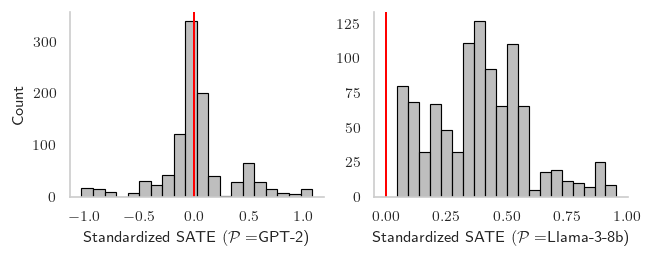

In [81]:
dataset_paths = pd.read_csv('all_df_paths.csv')['df_path'].values.tolist()
sates_dict = {'gpt2': [], 'llama-3-8b': []}
for df_path in tqdm(dataset_paths):
    df = pd.read_csv(df_path)
    df = add_normalized_colums(
        data_df=df,
        outcome_index=outcome_index,
        possible_outcome_values=possible_outcome_values,
        treatment_index=treatment_index,
        possible_treatment_values=possible_treatment_values
    )
    model_name = df_path.split('/')[2]
    sd_y = df['P(X13=2)'].std()
    y1 = df['P(X13=2)|do(X12=1)']
    y0 = df['P(X13=2)|do(X12=0)']
    ites = y1 - y0
    sate = ites.mean() / sd_y
    sates_dict[model_name].append(sate)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2), dpi=120)
axes = axes.ravel()
sns.histplot(x=sates_dict['gpt2'], ax=axes[0], bins=20, color='darkgray', edgecolor='black')
axes[0].axvline(x=0, color='red')
axes[0].set_xlabel(r'Standardized SATE $(\mathcal{P}=$GPT-2)')
axes[0].grid(None)
sns.histplot(x=sates_dict['llama-3-8b'], ax=axes[1], bins=20, color='darkgray', edgecolor='black')
axes[1].axvline(x=0, color='red')
axes[1].set_xlabel(r'Standardized SATE $(\mathcal{P}=$Llama-3-8b)')
axes[1].set_ylabel('')
axes[1].grid(None)
sns.despine()
plt.show() 